In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.activations import linear, relu, sigmoid

In [2]:
# new data

data_new=pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')


# old data

data_old=pd.read_csv('/kaggle/input/old-data/used_cars.csv')


# reformatting old data

data_old['milage'] = data_old['milage'].str.replace('mi.', '')
data_old['milage'] = data_old['milage'].str.replace(',', '')
data_old['price'] = data_old['price'].str.replace('$', '')
data_old['price'] = data_old['price'].str.replace(',', '')

data_old['milage']=data_old['milage'].apply(pd.to_numeric)
data_old['price']=data_old['price'].apply(pd.to_numeric)

new_id=pd.DataFrame(np.arange(188533,192542,1),columns=['id'])
data_old=pd.concat([new_id,data_old],axis=1)

# final data

data=pd.concat([data_new,data_old],axis=0,ignore_index=True)
data.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [3]:
# one-hot encoding

numerical_data=data[['milage','model_year']]
categorical_data=data[['fuel_type','accident','clean_title','brand','transmission','engine']]


ohe=OneHotEncoder(handle_unknown='ignore').fit(categorical_data)
ohe_data = ohe.transform(categorical_data).toarray()

In [4]:
# normalize numerical data

norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(np.array(numerical_data))  # learns mean, variance
numerical_data_norm=pd.DataFrame(norm_l(numerical_data),columns=['milage','model_year'])
numerical_data_norm

,milage,model_year
0,2.955089,-1.555976
1,1.555930,-2.437700
2,1.425161,-2.437700
3,-0.926448,0.207472
4,-1.169410,0.912851
...,...,...
192537,-1.303288,1.265541
192538,-1.098961,1.089196
192539,-1.275165,1.089196
192540,-0.655643,0.736506


In [5]:
X=pd.concat([numerical_data_norm,pd.DataFrame(ohe_data)],axis=1)
X

,milage,model_year,0,1,2,3,4,5,6,7,...,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277
0,2.955089,-1.555976,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.555930,-2.437700,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.425161,-2.437700,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.926448,0.207472,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.169410,0.912851,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192537,-1.303288,1.265541,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192538,-1.098961,1.089196,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192539,-1.275165,1.089196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192540,-0.655643,0.736506,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# input shape

X.shape

(192542, 1280)

In [7]:
# output 

y=data[['price']]

# output shape

y.shape

(192542, 1)

In [8]:
# NN

tf.random.set_seed(1234)  # applied to achieve consistent results
model = Sequential(
    [
        tf.keras.Input(shape=(X.shape[1],)),
        Dense(256, activation='relu'),
        Dense(128,activation='relu'),
        Dense(32,activation='relu'),
        Dense(1, activation='linear')
     ]
)

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 364,993 (1.39 MB)

 Trainable params: 364,993 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
callback=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=True)


model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(
    X,y,
    validation_split=0.2,
    epochs=100,
    callbacks=[callback]
)

Epoch 1/100


I0000 00:00:1726503427.947924      65 service.cc:145] XLA service 0x7c6e400016c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726503427.947970      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 108/4814 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 8857402368.0000

I0000 00:00:1726503428.806125      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4814/4814 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 5862877696.0000 - val_loss: 5284887552.0000
Epoch 2/100
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5279235072.0000 - val_loss: 5214094848.0000
Epoch 3/100
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5239961600.0000 - val_loss: 5197231616.0000
Epoch 4/100
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5222796800.0000 - val_loss: 5191336960.0000
Epoch 5/100
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5211293184.0000 - val_loss: 5188774912.0000
Epoch 6/100
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5202208768.0000 - val_loss: 5187682816.0000
Epoch 7/100
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 5194613248.0000 - val_loss: 5187101184.0000
Epoch 8/100
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5187999744.0000 - val_loss: 5187713024.0000
Epoch 9/100
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5182070784.0000 - val_loss: 5188812288.0000
Epoch 10/100
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 8s 2

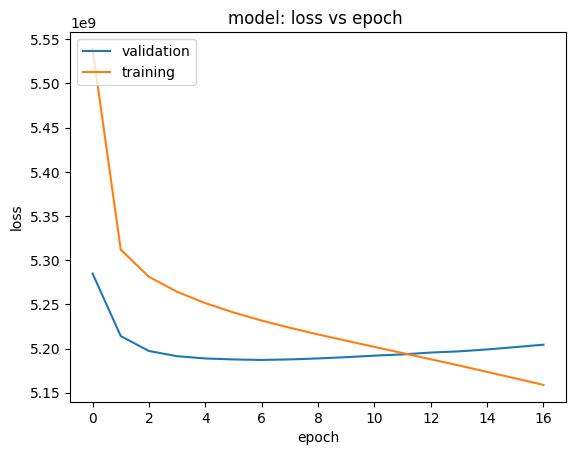

In [11]:
# plotting history

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model: loss vs epoch ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation','training'], loc='upper left')
plt.show()

In [12]:
# prediction on unlabeled data

unlabeled_data=pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
test_ids=unlabeled_data['id']
numerical_data=unlabeled_data[['milage','model_year']]
categorical_data=unlabeled_data[['fuel_type','accident','clean_title','brand','transmission','engine']]
ohe_data = ohe.transform(categorical_data).toarray()

numerical_data_norm=pd.DataFrame(norm_l(numerical_data),columns=['milage','model_year'])

X=pd.concat([numerical_data_norm,pd.DataFrame(ohe_data)],axis=1)

predictions=model.predict(X)


# submission file 

print('Generating submission.csv file...')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions.flatten()]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv

3928/3928 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Generating submission.csv file...


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


id,label
188533,18347
188534,82822
188535,62780
188536,29655
188537,30843
188538,21481
188539,10396
188540,52357
188541,103275
